In [1]:

from google.colab import drive 
import sys                     
import pandas as pd
import numpy as np
import json                    
import matplotlib.pyplot as plt
import scipy.signal as signal 
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [59]:
# Sample raw_data
data_path = '/content/SubA_2kph_Group_1.txt'

df = pd.read_csv(data_path, sep='\t', header=None)

def extract_sensor_data(df, start_col, end_col):

    return df.iloc[:, start_col:end_col]

# Define column ranges
qua_f = extract_sensor_data(df, 0, 4)
qua_s = extract_sensor_data(df, 4, 8)
qua_t = extract_sensor_data(df, 8, 12)
acc_f = extract_sensor_data(df, 12, 15)
acc_s = extract_sensor_data(df, 15, 18)
acc_t = extract_sensor_data(df, 18, 21)
gyr_f = extract_sensor_data(df, 21, 24)
gyr_s = extract_sensor_data(df, 24, 27)
gyr_t = extract_sensor_data(df, 27, 30)
emg = extract_sensor_data(df, 30, 32)
fsr = extract_sensor_data(df, 32, 35)
print(qua_f)

            0       1       2       3
0      0.1835  0.0372 -0.7700 -0.6100
1      0.1835  0.0371 -0.7701 -0.6099
2      0.1835  0.0371 -0.7701 -0.6098
3      0.1836  0.0371 -0.7701 -0.6098
4      0.1836  0.0371 -0.7701 -0.6098
...       ...     ...     ...     ...
26566  0.3616  0.2777 -0.7128 -0.5330
26567  0.3616  0.2777 -0.7128 -0.5330
26568  0.3616  0.2777 -0.7128 -0.5330
26569  0.3616  0.2776 -0.7128 -0.5330
26570  0.3617  0.2776 -0.7128 -0.5330

[26571 rows x 4 columns]


In [37]:
def quat2rot(Q):
    """
    Convert a quaternion to a 3x3 rotation matrix.
    Parameters:
    Q (list or numpy array): A quaternion as a list or numpy array [q0, q1, q2, q3].
    Returns:
    numpy array: A 3x3 rotation matrix.
    """
    q0, q1, q2, q3 = Q

    r00 = 2 * (q0*q0 + q1*q1) - 1
    r01 = 2 * (q1*q2 - q0*q3)
    r02 = 2 * (q1*q3 + q0*q2)
    r10 = 2 * (q1*q2 + q0*q3)
    r11 = 2 * (q0*q0 + q2*q2) - 1
    r12 = 2 * (q2*q3 - q0*q1)
    r20 = 2 * (q1*q3 - q0*q2)
    r21 = 2 * (q2*q3 + q0*q1)
    r22 = 2 * (q0*q0 + q3*q3) - 1

    R_GS = np.array([[r00, r01, r02],
                     [r10, r11, r12],
                     [r20, r21, r22]])

    return R_GS


\begin{align*}
&\text{Calculate rotation matrix from upper to lower frame (post-multiply)} \\
&R^k = R^{t}_{BS}R^{t}_{GB} \times (R^{s}_{BS}R^{s}_{GB})^{-1} \\
&R^{a} = R^{s}_{BS}R^{s}_{GB} \times (R^{f}_{BS}R^{f}_{GB})^{-1} \\
& \\
&\text{Where } R_{BS} \text{ and } R_{GB}\text{ represent the rotation matrix from the body frame (B) to the sensor frame (S) and the global frame (G) to the body frame (B) regarding to tight (t), shank (s), foot (f) segments, respectitively.} \\
&\text{Note: } R_{BS} = (R_{SB})^{-1} = (R_{SB})^T \\
& \\
&\text{Calculate rotation angle of each joint} \\
&\theta_k = \arctan\left(\frac{R^{k}_{(1,1)}}{R^{k}_{(2,1)}}\right) \\
&\theta_a = \arctan\left(\frac{R^{a}_{(1,1)}}{R^{a}_{(2,1)}}\right) \\
\end{align*}



In [63]:
#Joint Angle Calculation
'''
# Extract the quaternion columns by header names
quat_columns = ['quat_1', 'quat_2', 'quat_3', 'quat_4']
qua_t= df_t[quat_columns].values
qua_s= df_s[quat_columns].values
qua_f= df_f[quat_columns].values
'''
# Define 3x3 matrices for R_SB_t, R_SB_s, and R_SB_f with specific values (Generate body frame to sensor frame rotation matrices R_BS)
R_BS_t = np.array([[-0.9972, 0.0716, -0.0221],
                   [0.0674, 0.9858, 0.1538],
                   [0.0328, 0.1519, -0.9879]])

R_BS_s = np.array([[0.2169, 0.9756, 0.0327],
                   [0.9652, -0.2194, 0.1426],
                   [0.1463, 0.0006, -0.9892]])

R_BS_f = np.array([[-0.8464, 0.2182, -0.4858],
                   [0.2039, 0.9755, 0.0830],
                   [0.4920, -0.0288, -0.8701]])

# Preallocate arrays for angle_k and angle_a
IMU_r, _ = qua_t.shape
angle_k = np.zeros(IMU_r)
angle_a = np.zeros(IMU_r)
angle_a_ori = np.zeros(IMU_r)
import torch

# Convert quaternions to rotation matrices and calculate angles
for i in range(IMU_r):
    Q_t = qua_t.iloc[i]
    Q_s = qua_s.iloc[i]
    Q_f = qua_f.iloc[i]

    R_GB_t = quat2rot(Q_t)
    R_GB_s = quat2rot(Q_s)
    R_GB_f = quat2rot(Q_f)

    R_k = np.dot(R_BS_t, R_GB_t) * np.linalg.inv(np.dot(R_BS_s, R_GB_s))
    R_a = np.dot(R_BS_s, R_GB_s) * np.linalg.inv(np.dot(R_BS_f, R_GB_f))

    angle_k[i] = np.arctan2(R_k[0, 0], R_k[1, 0])
    angle_a_ori[i] =  np.arctan2(R_a[0, 0], R_a[1, 0])

    angle_a[i] = -angle_a_ori[i]+90 # Since the configuraion was rotated


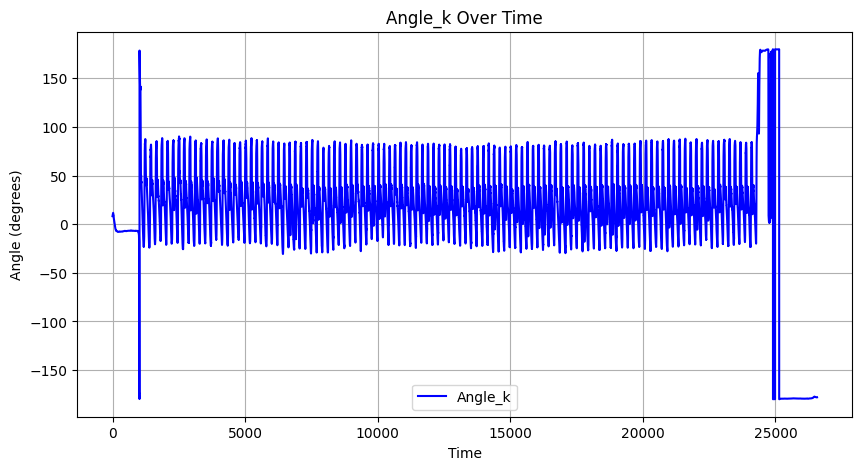

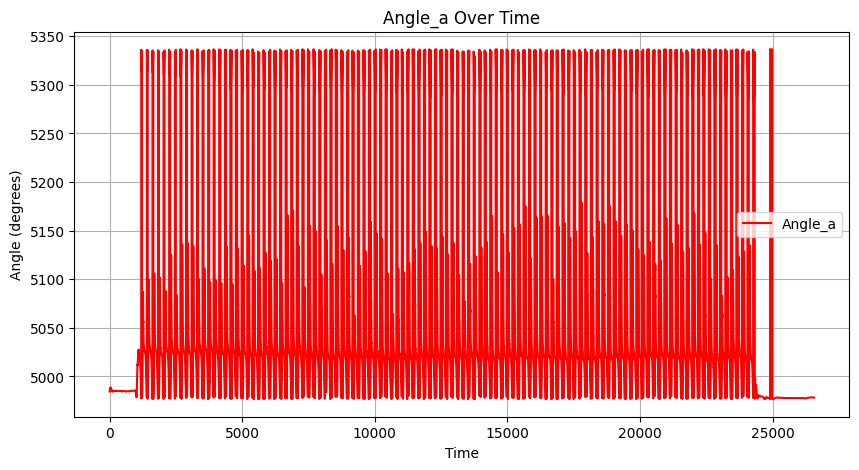

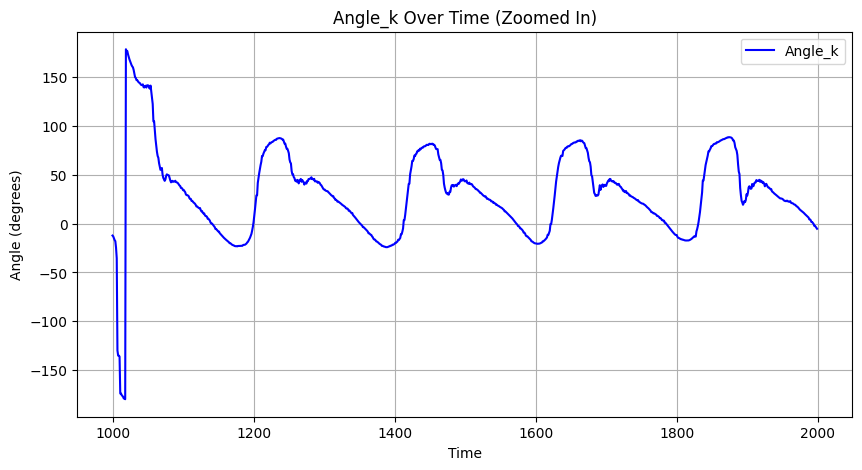

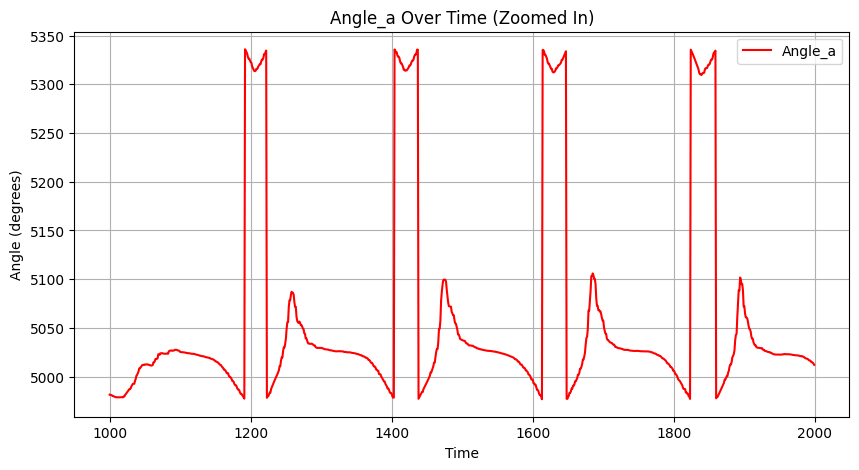

In [98]:
import matplotlib.pyplot as plt
import numpy as np


time = range(IMU_r)  

# Plot angle_k
plt.figure(figsize=(10, 5))
plt.plot(time, angle_k_deg, label='Angle_k', color='blue')
plt.xlabel('Time')
plt.ylabel('Angle (degrees)')
plt.title('Angle_k Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Plot angle_a
plt.figure(figsize=(10, 5))
plt.plot(time, angle_a_deg, label='Angle_a', color='red')
plt.xlabel('Time')
plt.ylabel('Angle (degrees)')
plt.title('Angle_a Over Time')
plt.grid(True)
plt.legend()
plt.show()

start_time = 1000  # Start time index
end_time = 2000    # End time index

# Plot angle_k within the specified time range
plt.figure(figsize=(10, 5))
plt.plot(time[start_time:end_time], angle_k_deg[start_time:end_time], label='Angle_k', color='blue')
plt.xlabel('Time')
plt.ylabel('Angle (degrees)')
plt.title('Angle_k Over Time (Zoomed In)')
plt.grid(True)
plt.legend()
plt.show()

# Plot angle_a within the specified time range
plt.figure(figsize=(10, 5))
plt.plot(time[start_time:end_time], angle_a_deg[start_time:end_time], label='Angle_a', color='red')
plt.xlabel('Time')
plt.ylabel('Angle (degrees)')
plt.title('Angle_a Over Time (Zoomed In)')
plt.grid(True)
plt.legend()
plt.show()


In [66]:

# Preallocate arrays for FSR data
r_fsr, _ = fsr.shape
fsr_flag = 0
refined_FSR = np.zeros(r_fsr)
tm = 0 # Timer

thr1 = 2.5 
thr2 = 2.5 

for i in range(len(fsr)):
    if fsr_flag == 0:
        tm=0

    if fsr.iloc[i, 2] > thr1:  
        fsr_flag=1

  
        fsr_flag = 0 
 
    if fsr_flag == 1:
        refined_FSR[i] = 1  # Stance phase
        tm += 1  # Increase timer during stance
    elif fsr_flag == 0:
        refined_FSR[i] = 0  # Swing phase
        tm = 0  # Reset the timer when in swing phase

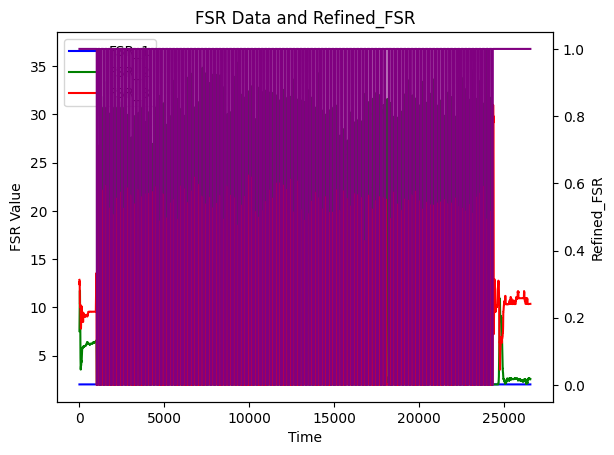

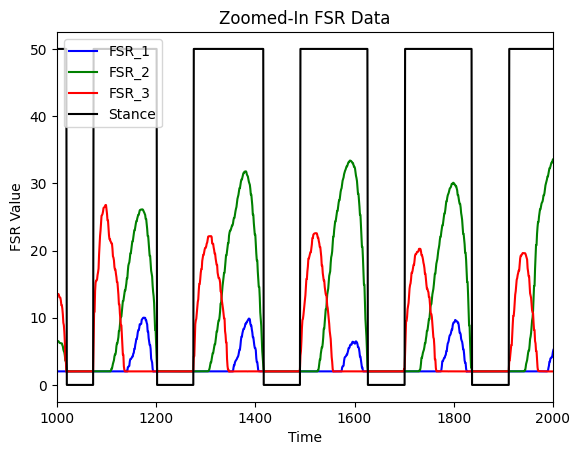

In [68]:

time = range(r_fsr)

fig, ax1 = plt.subplots()

ax1.plot(time, fsr.iloc[:, 0], label='FSR_1', color='b')  
ax1.plot(time, fsr.iloc[:, 1], label='FSR_2', color='g')  
ax1.plot(time, fsr.iloc[:, 2], label='FSR_3', color='r')  

ax1.set_xlabel('Time')
ax1.set_ylabel('FSR Value')
ax1.set_title('FSR Data and Refined_FSR')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(time, refined_FSR, label='Refined_FSR', color='purple')
ax2.set_ylabel('Refined_FSR')

fig2, ax3 = plt.subplots()
ax3.plot(time, fsr.iloc[:, 0], label='FSR_1', color='b')  
ax3.plot(time, fsr.iloc[:, 1], label='FSR_2', color='g')  
ax3.plot(time, fsr.iloc[:, 2], label='FSR_3', color='r') 
ax3.plot(time, refined_FSR*50, label='Stance', color='k')
ax3.set_xlabel('Time')
ax3.set_ylabel('FSR Value')
ax3.set_title('Zoomed-In FSR Data')
ax3.legend(loc='upper left')

# Specify the zoomed-in time range here
zoom_start = 1000  # Start index for zoomed-in view
zoom_end = 2000    # End index for zoomed-in view

# Set the x-axis limits for the zoomed-in plot
ax3.set_xlim(zoom_start, zoom_end)

plt.show()

In [76]:
m, n = qua_f.shape # Size of data
delta1 = np.zeros((5, 3))
T_c1 = 0
Lock1 = 0
Timer1 = 0
window1 = np.zeros(3)
SW_SD1 = np.zeros(m)

Df1 = np.zeros(m)
Tm = 30 # Time set constant
vv1 = np.zeros(m)
H1 = np.zeros(m)
V_WD1 = np.zeros(2)
# Array to store the values of a1 for plotting
a1_values = np.zeros((m, 3))
acc_pre = np.zeros_like(acc_f)  
delta = np.zeros((5, 3))  # Initialize delta with zeros
D = np.zeros(m)  # Initialize D with zeros
Df = np.zeros(m)  # Initialize Df with zeros
H = np.zeros(m)  # Initialize H with zeros
SW_SD = np.zeros((m, 1))  # Initialize SW_SD with zeros
window = np.zeros(3)  # Initialize window with zeros
V_WD = np.zeros(2)  # Initialize V_WD with zeros
vv = np.zeros(m)
T_c = 0
Lock = 0
Timer = 0


# IMU-based swing foot detection Algorithm
for i in range(m):
    rot_gs1 = quat2rot(qua_f.iloc[i, :])

    acc_pre[i,:] = np.dot(rot_gs1, acc_f.iloc[i, :]) - np.array([0, 0, 9.8]) # Gravity free acceleration

    sq_delta = np.sum(delta**2, axis=0)
    delta[:4, :] = delta[1:, :]
    delta[4, :] = acc_pre[i, :]

    
    D[i] = np.mean(sq_delta * np.std(delta,axis=0))

    if i > 0:
        Df[i] = 0.9 * D[i] + 0.1 * Df[i - 1]  # Smoothing singal from noise

    if Df[i] > 50:
        H[i] = 0  # Toe-off (swing phase)
    elif Df[i] < 0.1:
        H[i] = 1  # Stance phase
    else:
        H[i] = H[i - 1]  # Maintain previous state if in between thresholds

    if H[i] == 1:
        T_c += 1
    else:
        T_c = 0

    if H[i] == 0 and Lock == 0:
        Lock = 1

    if Lock == 1:
        Timer += 1
        SW_SD[i, 0] = 1
        window[:2] = window[1:]
        window[2] = Df[i]
        V_WD[1] = window[2] - window[1]
        V_WD[0] = window[1] - window[0]
        V_WD_s= sum(V_WD)
        vv[i] = V_WD_s
    if Timer > 30:
        if V_WD[1] > 80 or (V_WD[0] > 80 and V_WD[1] > 80 and V_WD_s > 200):  # Here the value is offset threshold value of Derviative Maneuver factor
            SW_SD[i, 0] = 0
            Lock = 2

    if Lock == 2:
        SW_SD[i, 0] = 0
        Timer = 0
        window = np.zeros(3)

    if H[i] == 1 and Lock == 2 and T_c > 10:
        Lock = 0
        Timer = 0
        SW_SD[i, 0] = 0
        window = np.zeros(3)

    if T_c > 10:
        SW_SD[i, 0] = 0
        Lock = 0
        Timer = 0

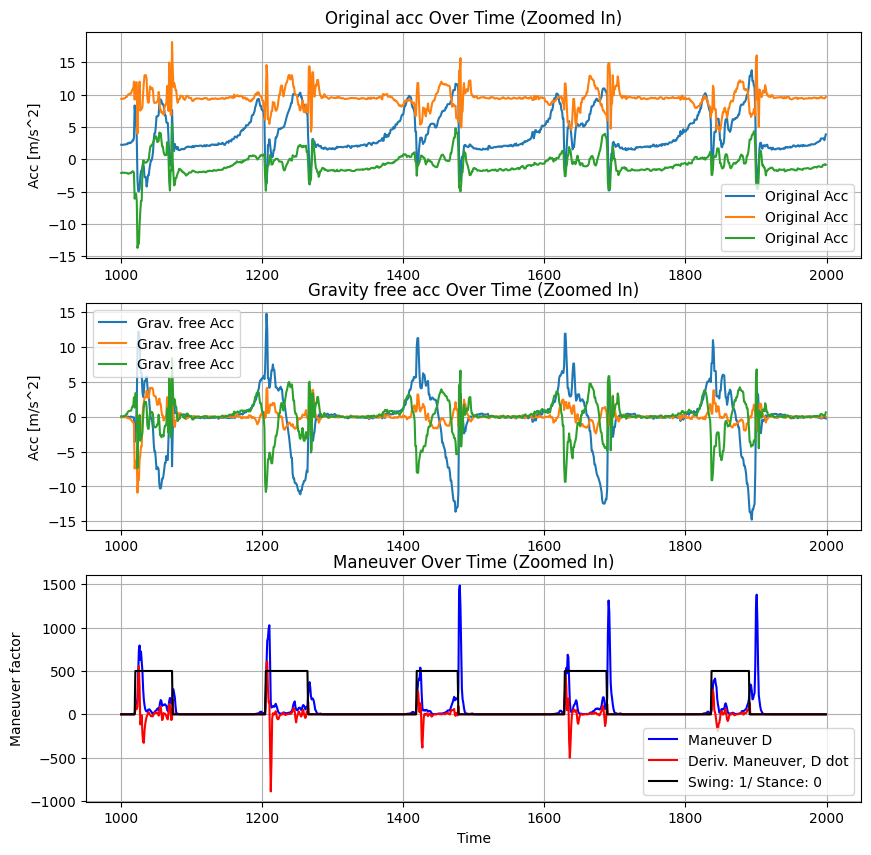

In [77]:
# Define the time range you want to zoom in on
start_time = 1000  # Start time index
end_time = 2000    # End time index
# Figure for each data
plt.figure(figsize=(10, 10))

# Df subplot
plt.subplot(3, 1, 1)
plt.plot(time[start_time:end_time], acc_f[start_time:end_time], label='Original Acc')
plt.ylabel('Acc [m/s^2]')
plt.title('Original acc Over Time (Zoomed In)')
plt.grid(True)
plt.legend()

# vv subplot
plt.subplot(3, 1, 2)
plt.plot(time[start_time:end_time], acc_pre[start_time:end_time], label='Grav. free Acc')
plt.ylabel('Acc [m/s^2]')
plt.title('Gravity free acc Over Time (Zoomed In)')
plt.grid(True)
plt.legend()

# SW_SD subplot
plt.subplot(3, 1, 3)
plt.plot(time[start_time:end_time], Df[start_time:end_time], label='Maneuver D', color='blue')
plt.plot(time[start_time:end_time], vv[start_time:end_time], label='Deriv. Maneuver, D dot', color='r')
plt.plot(time[start_time:end_time], 500*SW_SD[start_time:end_time], label='Swing: 1/ Stance: 0', color='k')
plt.xlabel('Time')
plt.ylabel('Maneuver factor')
plt.title('Maneuver Over Time (Zoomed In)')
plt.grid(True)
plt.legend()

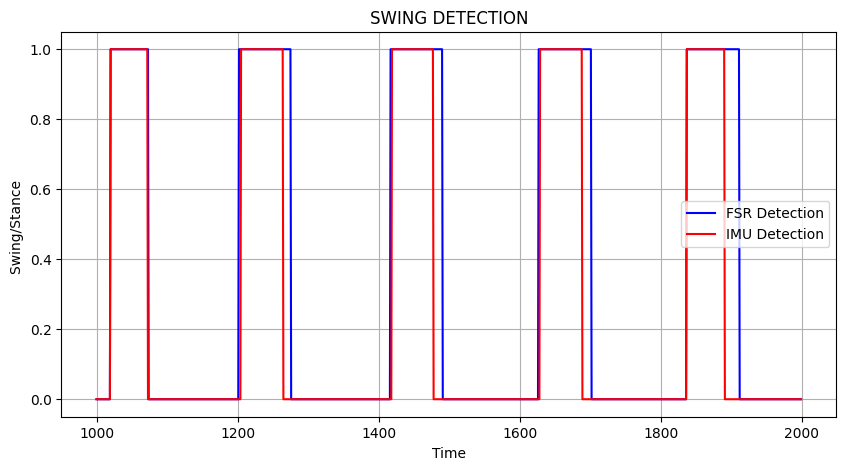

In [81]:
import matplotlib.pyplot as plt

# Flip FSR data for stance detection
SW_FSR = 1 - refined_FSR  # Flip FSR data to match IMU detection logic (0 = swing, 1 = stance)

start_time = 1000  # Start time index
end_time = 2000    # End time index

# Create the plot for FSR-based detection and IMU-based detection
plt.figure(figsize=(10, 5))

# Plot FSR-based detection
plt.plot(range(start_time, end_time), SW_FSR[start_time:end_time], label='FSR Detection', color='blue')

# Plot IMU-based detection
plt.plot(range(start_time, end_time), SW_SD[start_time:end_time], label='IMU Detection', color='red')

plt.xlabel('Time')
plt.ylabel('Swing/Stance ')
plt.title('SWING DETECTION')

plt.grid(True)
plt.legend()
plt.show()


In [87]:

Fs = 100  
highpass_freq = 25  # High-pass filter frequency
lowpass_freq = 4   # Low-pass filter frequency

# Initialize arrays to store filtered EMG data for each channel
filtered_emg_data = np.zeros_like(emg)
Data_hp = np.zeros_like(emg)
Data_rf = np.zeros_like(emg)
Data_lp = np.zeros_like(emg)


for channel in range(emg.shape[1]):

    highpass_filter= signal.butter(4, highpass_freq / (0.5 * Fs), btype='high')

    Data_hp[:, channel] = signal.filtfilt(highpass_filter[0], highpass_filter[1], emg.iloc[:, channel])

    Data_rf[:, channel]= np.abs(Data_hp[:, channel])

    lowpass_filter = signal.butter(4, lowpass_freq / (0.5 * Fs), btype='low')

    Data_lp[:, channel] = signal.filtfilt(lowpass_filter[0], lowpass_filter[1], Data_rf[:, channel])

    filtered_emg_data[:, channel] = Data_lp[:, channel]

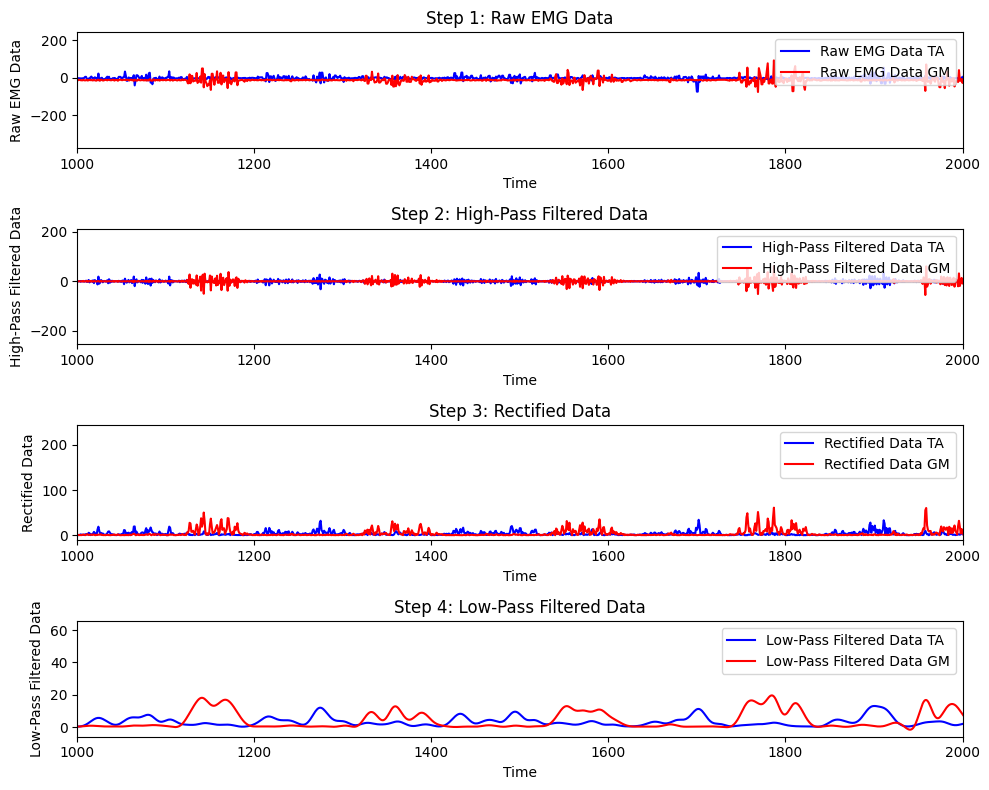

In [88]:

time = np.arange(len(emg))

fig, axs = plt.subplots(4, figsize=(10, 8))

# Plot the raw EMG data
axs[0].plot(time, emg.iloc[:, 0], label='Raw EMG Data TA', color='b')
axs[0].plot(time, emg.iloc[:, 1], label='Raw EMG Data GM', color='r')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Raw EMG Data')
axs[0].set_title('Step 1: Raw EMG Data')
axs[0].legend(loc='upper right')

# Plot the high-pass filtered data
axs[1].plot(time, Data_hp[:, 0], label='High-Pass Filtered Data TA', color='b')
axs[1].plot(time, Data_hp[:, 1], label='High-Pass Filtered Data GM', color='r')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('High-Pass Filtered Data')
axs[1].set_title('Step 2: High-Pass Filtered Data')
axs[1].legend(loc='upper right')

# Plot the rectified data
axs[2].plot(time, Data_rf[:, 0], label='Rectified Data TA', color='b')
axs[2].plot(time, Data_rf[:, 1], label='Rectified Data GM', color='r')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Rectified Data')
axs[2].set_title('Step 3: Rectified Data')
axs[2].legend(loc='upper right')

# Plot the low-pass filtered data
axs[3].plot(time, Data_lp[:, 0], label='Low-Pass Filtered Data TA', color='b')
axs[3].plot(time, Data_lp[:, 1], label='Low-Pass Filtered Data GM', color='r')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Low-Pass Filtered Data')
axs[3].set_title('Step 4: Low-Pass Filtered Data')
axs[3].legend(loc='upper right')

zoom_start = 1000  # Start index for zoomed-in view
zoom_end = 2000    # End index for zoomed-in view

# Set the x-axis limits for the zoomed-in plots
for ax in axs:
    ax.set_xlim(zoom_start, zoom_end)

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

plt.show()


In [90]:

def seperate_step(vector):
    step_num = 0
    step_time_data = []
    for i in range(1, len(vector)):
        if vector[i - 1] > vector[i]:
            if step_num >= len(step_time_data) or step_time_data[step_num][0] == 0:
                step_time_data.append([i, 0, 0])
            else:
                step_time_data[step_num][2] = i - 1
                step_num += 1
                step_time_data.append([i, 0, 0])

        if vector[i - 1] < vector[i]:
            if step_num < len(step_time_data):
                step_time_data[step_num][1] = i

    # Remove incomplete step data
    step_time_data = [s for s in step_time_data if 0 not in s]

    return step_time_data

def extraction_gait_parm(step_time_data, acc, time, swing):
    dT = 0.01

    stride_time = []
    swing_time = []
    cadence = []
    stride_length = []
    gait_velocity = []

    for step in step_time_data:
        dt = 0.01
        foot_v = np.array([0.0, 0.0])
        foot_p = np.array([0.0, 0.0])

        for j in range(step[0], step[2]):
            foot_v += acc[j, 1:2] * dt
            foot_p += foot_v * dt

        foot_p += foot_v * dt
        stride_t = (time[step[2]] - time[step[0]])*dt
        swing_t = (time[step[2]] - time[step[1]])*dt
        stride_len = np.sqrt(foot_p[0]**2 + foot_p[1]**2)

        stride_time.append(stride_t)
        swing_time.append(swing_t)
        cadence.append(2 * 60 / stride_t)
        stride_length.append(stride_len)
        gait_velocity.append(stride_len / stride_t)

    out = {
        'strideTime': stride_time,
        'swingTime': swing_time,
        'stanceDuration': [s / st for s, st in zip(swing_time, stride_time)],
        'cadence': cadence,
        'strideLength': stride_length,
        'gaitVelocity': gait_velocity
    }

    return out

# Create a time vector (assuming you have one, replace it with your time data)
vector = refined_FSR
time = np.arange(len(vector))
step_time_data = seperate_step(vector)
out = extraction_gait_parm(step_time_data, acc_pre, time, vector)
# Calculate statistics

def calculate_statistics(data):
    return {
        'max': np.max(data),
        'min': np.min(data),
        'mean': np.mean(data),
        'std': np.std(data)
    }

# Extracting gait parameters from the output of the extraction function
statistics = {
    'Swing Time [s]': calculate_statistics(out['swingTime']),
    'Stride Time [s]': calculate_statistics(out['strideTime']),
    'Stance Ratio [%]': calculate_statistics(out['stanceDuration']),
    'Stride Length [m]': calculate_statistics(out['strideLength']),
    'Gait Speed [m/s]': calculate_statistics(out['gaitVelocity']),
    'Cadence [steps/min]': calculate_statistics(out['cadence'])
}

# Convert the statistics to a DataFrame for a clear view
df_statistics = pd.DataFrame(statistics)

# Print the statistics data
print(df_statistics)

      Swing Time [s]  Stride Time [s]  Stance Ratio [%]  Stride Length [m]  \
max         1.770000         2.500000          0.793103           1.896199   
min         1.270000         1.740000          0.623810           0.010369   
mean        1.357027         2.086216          0.650664           0.661274   
std         0.049767         0.067678          0.018389           0.340467   

      Gait Speed [m/s]  Cadence [steps/min]  
max           1.089770            68.965517  
min           0.005033            48.000000  
mean          0.317858            57.581785  
std           0.169203             1.911325  
